<a href="https://colab.research.google.com/github/IvainGuittard/INF587/blob/main/CSC52087EP_lab1a_Basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC52087EP lab1a by Vicky Kalogeiton
# Ecole Polytechnique
# Basic GAN Notebook

In [33]:
# import the libraries
import torch, pdb
from torch import optim
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


## Setup

In [34]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor: 128 x 784 (Batch size = 128, 28*28 = 784)
  data=tensor.detach().cpu().view(-1,ch,*size) # 128 x 784 --> 128 x 1 x 28 x 28
  # matplotlib has a different order (Width ,Height ,Channels) than pytorch for images
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)   # 1 x 28 x 28  = 28 x 28 x 1
  plt.imshow(grid)
  plt.show()


In [35]:
# setup of the main parameters and hyperparameters
epochs = 200
cur_step = 0
# every how many steps we want to show information on the screen
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

#dimensionality of noise vector that is the input of the generator
z_dim = 64
# learning rate
lr = 0.00001
# Binary Cross Entropy with Logits (transfoms the output wiht a sigmoid from 0 to 1)
loss_func = nn.BCEWithLogitsLoss()

# batch size
bs = 128
device = 'cuda'

# 1. where to store the data (.), 2. download the data = True 3. tranform according to the Tensor structure
# 4. shuffle: at every epoch we shuffle the data, 5. batch size
dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=bs)

# every epoch is going to have number of steps:
# number of steps = 60000 / 128 = 468.75

## Declare the models
#### Fill in the missing blanks

In [36]:
# Generator
def generatorBlock(input, output):
  return nn.Sequential(
    nn.Linear(input, output),
    nn.BatchNorm1d(output),
    nn.ReLU(),
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, image_dim=784, h_dim=128): # z_dim: latent space dimensionality
    super().__init__()
    self.generator = nn.Sequential( # Fill in the rest by using the z_dim and the h_dim
        generatorBlock(z_dim, h_dim), # 64 --> 128
        generatorBlock(h_dim, h_dim*2), # 128 --> 256
        generatorBlock(h_dim*2, h_dim*4), # 256 --> 512
        generatorBlock(h_dim*4, h_dim*8), # 512 --> 1024
        generatorBlock(h_dim*8, image_dim), # 1024 --> 784
        nn.Sigmoid(), # to make the values between 0 and 1
    )

  def forward(self, noise):
       return self.generator(noise)

# function that generates noise
def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

In [37]:
## Discriminator
def discriminatorBlock(input, output):
  return nn.Sequential(
    nn.Linear(input, output),
    nn.LeakyReLU(0.2),
  )

class Discriminator(nn.Module):
  def __init__(self, image_dim=784, h_dim=256):
    super().__init__()
    self.discriminator=nn.Sequential( # Fill in the rest by using the image_dim and the h_dim
        discriminatorBlock(image_dim, h_dim*4), # 784 --> 1024
        discriminatorBlock(h_dim*4, h_dim*2), # 1024 --> 512
        discriminatorBlock(h_dim*2, h_dim), # 512 --> 256
        nn.Linear(h_dim, 1) # output: 256 --> 1
    )

  def forward(self, image):
      return self.discriminator(image)

## Main code

In [53]:
gen = Generator(z_dim).to(device)
# optimizer of the generator
gen_opt = optim.Adam(gen.parameters(), lr=lr) # Adam optimizer
disc = Discriminator().to(device)
# optimizer of the discriminator
disc_opt = optim.Adam(disc.parameters(), lr=lr/10) # Adam optimizer

In [54]:
# check your generator
gen

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=1024, out_features=784, bias=True)
      (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track

In [55]:
# check your discriminator
disc

Discriminator(
  (discriminator): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [56]:
x,y=next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([6, 4, 8, 3, 7, 4, 0, 6, 7, 4])


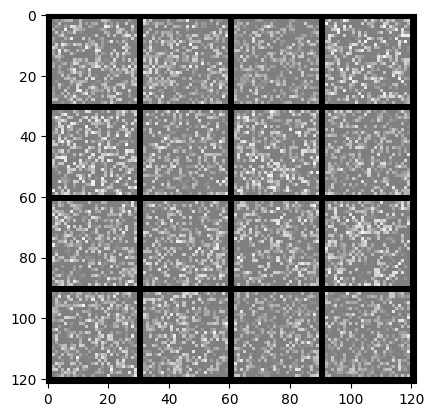

In [57]:
noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

# Here we see the initial output of passing the noise through the generator
# Since the generator did not start learning, it produces a very noisy output

## Compute the loss

In [58]:
# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim): # number is the number of elemenent we want to process, i.e. batch size
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   pred = disc(fake)
   targets=torch.ones_like(pred) # 1: real, 0: fake
   gen_loss=loss_func(pred,targets)

   return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   # number is the number of elemenent we want to process, i.e. batch size
   # real is the number of real images
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   disc_fake = disc(fake.detach()) # need to detach so that we do not change the generator
   disc_fake_targets=torch.zeros_like(disc_fake) # 1: real, 0: fake
   disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

   disc_real = disc(real)
   disc_real_targets=torch.ones_like(disc_real)
   disc_real_loss=loss_func(disc_real, disc_real_targets)

   disc_loss=(disc_fake_loss+disc_real_loss)/2

   return disc_loss



**GANs are known for their training instability and difficulty in achieving convergence. Discuss the potential causes of these issues**

The instability and the difficulty to converge for GANs is due to the fact that the generator and the discriminator are trained at the same time, and they are in a kind of competition. The generator tries to generate images that are as close as possible to the real images, while the discriminator tries to distinguish between the real and the fake images. This competition can lead to a situation where the generator and the discriminator are stuck in a kind of a local minimum, where the generator is not able to generate realistic images, and the discriminator is not able to distinguish between the real and the fake images.

## Training loop

  0%|          | 0/469 [00:00<?, ?it/s]

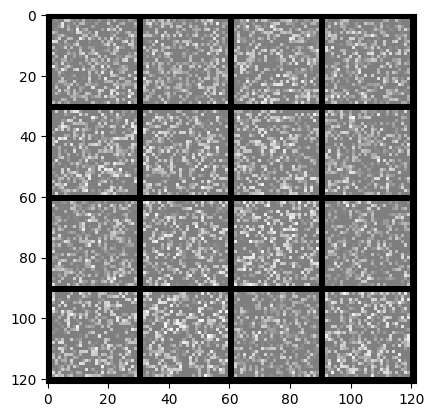

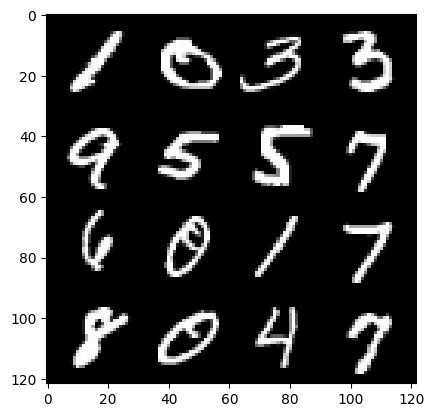

0: step 12900 / Gen loss: 0.8681650807460146 / disc_loss: 0.6121657494703935


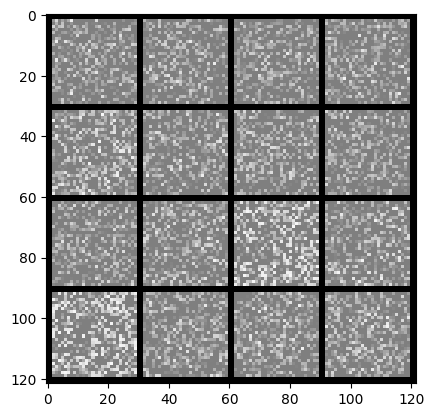

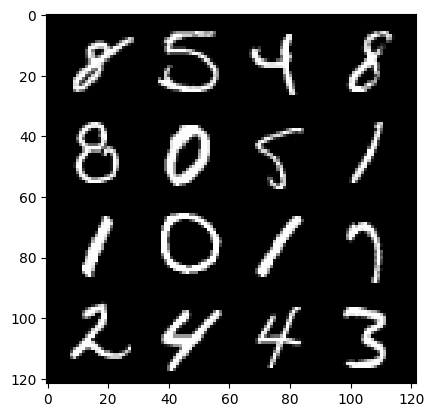

0: step 13200 / Gen loss: 0.8534197594722116 / disc_loss: 0.6097387063503265


  0%|          | 0/469 [00:00<?, ?it/s]

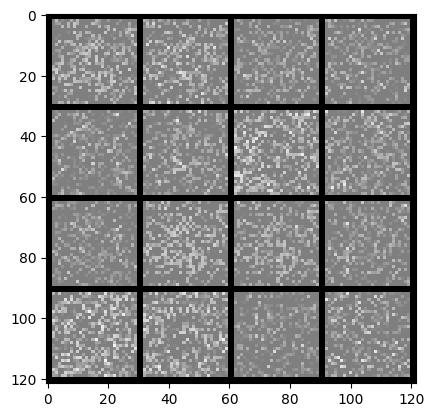

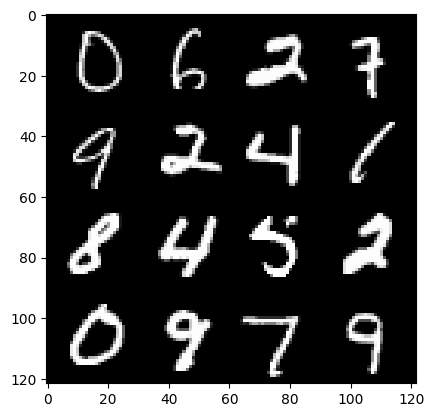

1: step 13500 / Gen loss: 1.1424886298179633 / disc_loss: 0.5091994013388949


  0%|          | 0/469 [00:00<?, ?it/s]

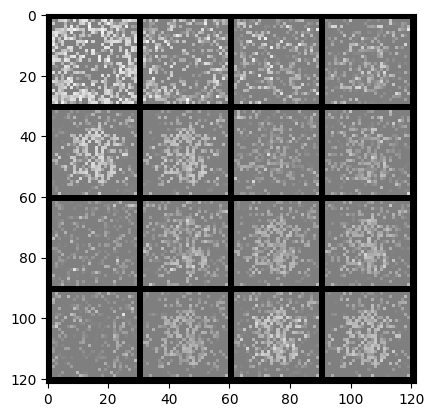

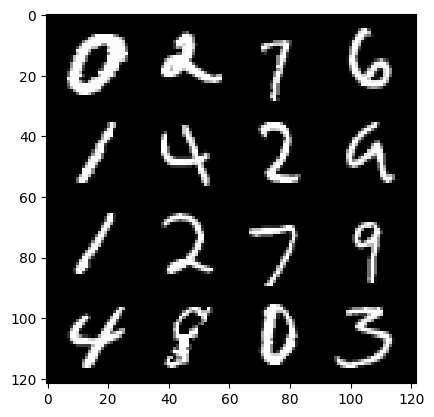

2: step 13800 / Gen loss: 1.5440419971942902 / disc_loss: 0.39766242782274885


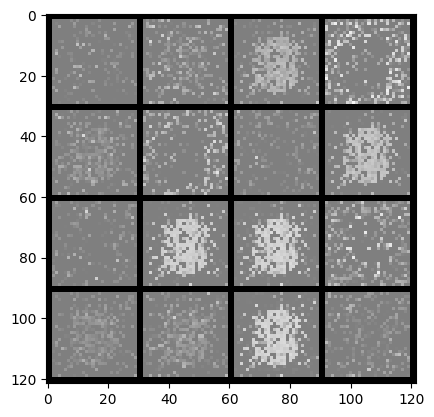

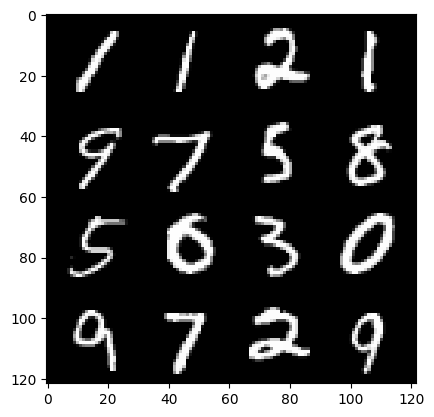

2: step 14100 / Gen loss: 2.025670830408731 / disc_loss: 0.29024031723539057


  0%|          | 0/469 [00:00<?, ?it/s]

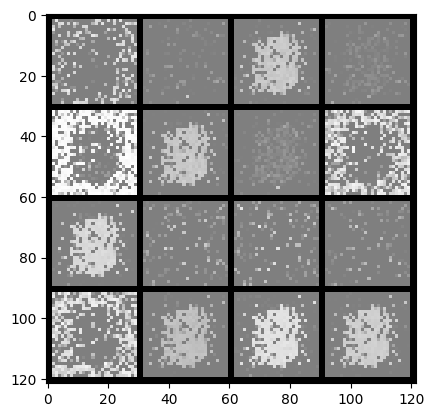

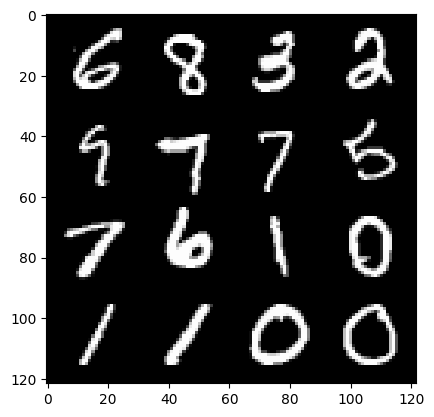

3: step 14400 / Gen loss: 2.5506191142400088 / disc_loss: 0.19946570371588065


  0%|          | 0/469 [00:00<?, ?it/s]

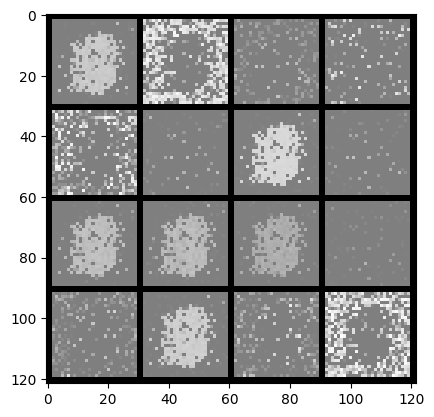

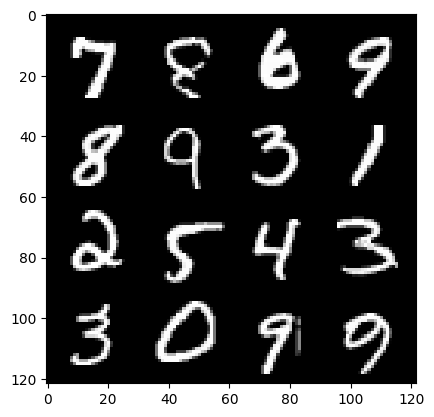

4: step 14700 / Gen loss: 3.0756597034136455 / disc_loss: 0.13103753276169297


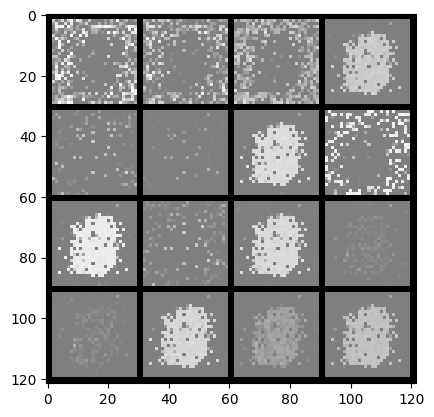

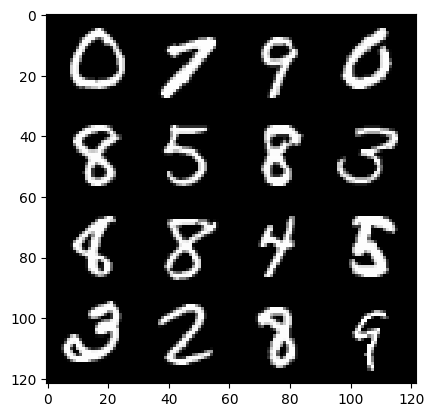

4: step 15000 / Gen loss: 3.585972296396891 / disc_loss: 0.08574010173479713


  0%|          | 0/469 [00:00<?, ?it/s]

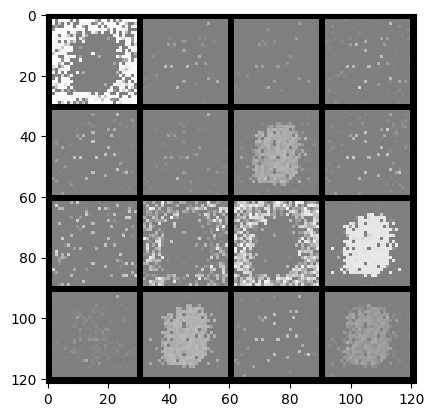

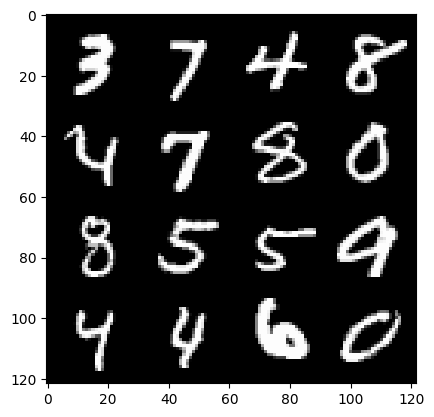

5: step 15300 / Gen loss: 4.0702517763773605 / disc_loss: 0.057345858328044376


  0%|          | 0/469 [00:00<?, ?it/s]

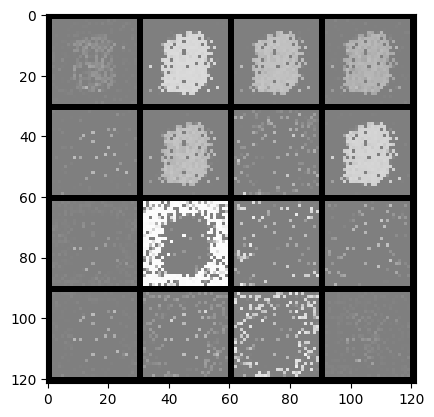

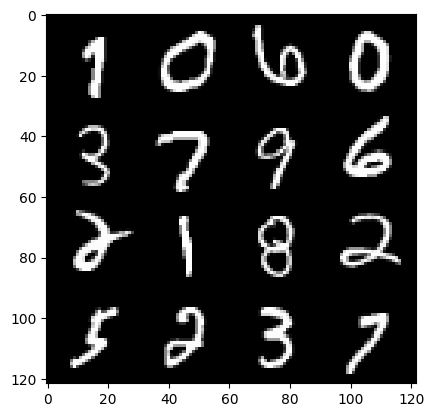

6: step 15600 / Gen loss: 4.516727449099224 / disc_loss: 0.03933662396545213


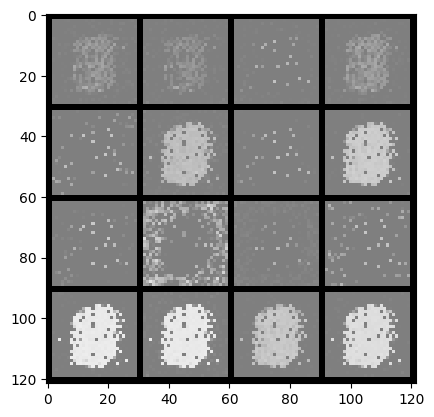

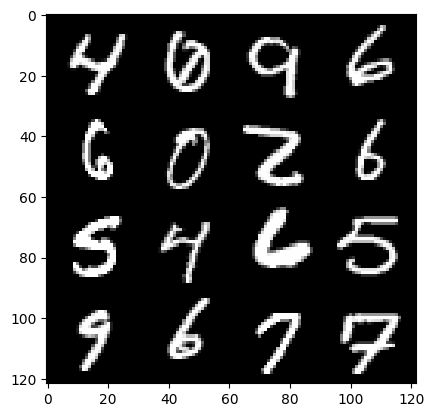

6: step 15900 / Gen loss: 4.926673652331033 / disc_loss: 0.02780094952632985


  0%|          | 0/469 [00:00<?, ?it/s]

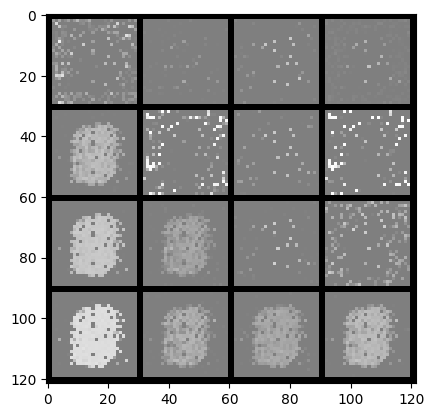

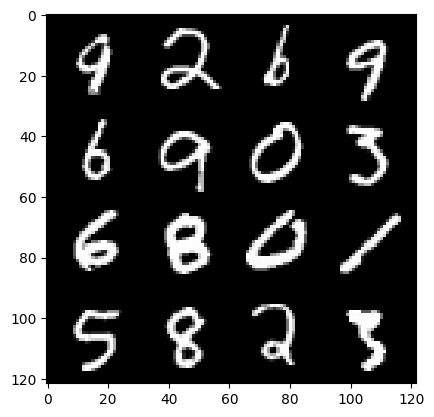

7: step 16200 / Gen loss: 5.312949272791547 / disc_loss: 0.02014818016129237


  0%|          | 0/469 [00:00<?, ?it/s]

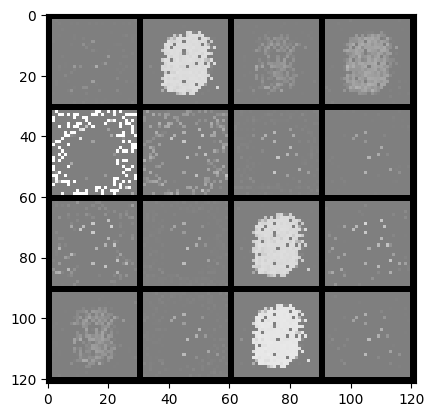

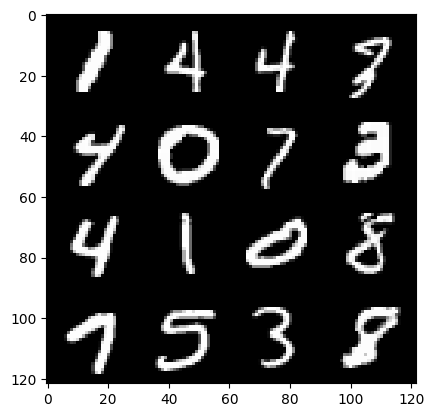

8: step 16500 / Gen loss: 5.663129814465843 / disc_loss: 0.014900740878656503


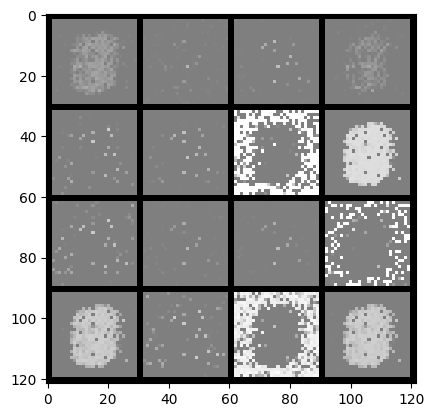

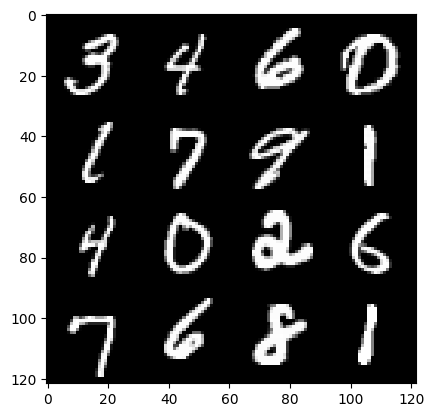

8: step 16800 / Gen loss: 6.003457907040914 / disc_loss: 0.01119586137123405


  0%|          | 0/469 [00:00<?, ?it/s]

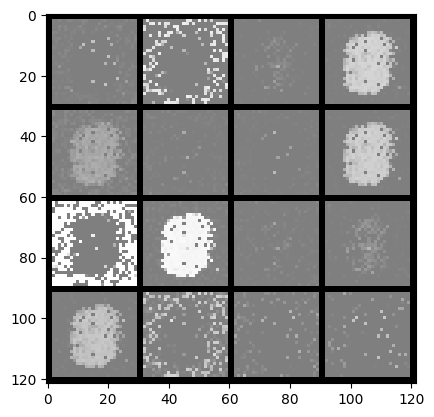

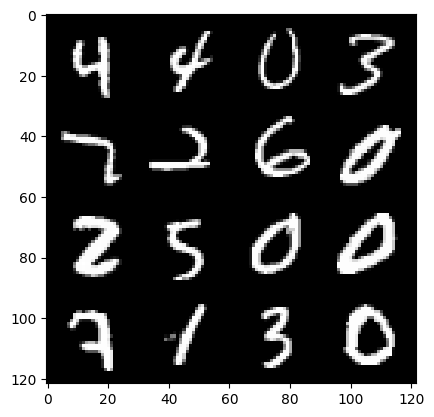

9: step 17100 / Gen loss: 6.3066672341028855 / disc_loss: 0.008594053949539859


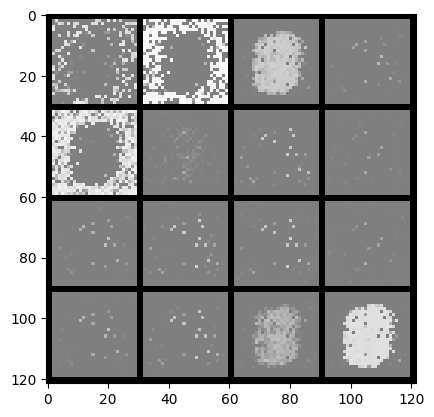

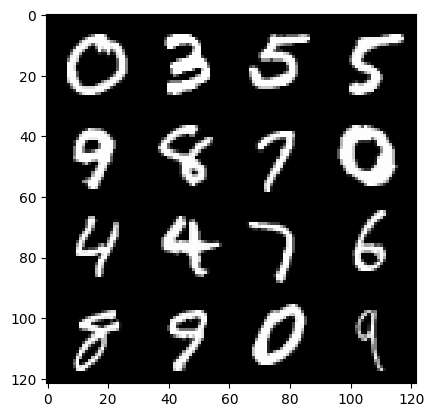

9: step 17400 / Gen loss: 6.6108333826065095 / disc_loss: 0.006680141723093887


  0%|          | 0/469 [00:00<?, ?it/s]

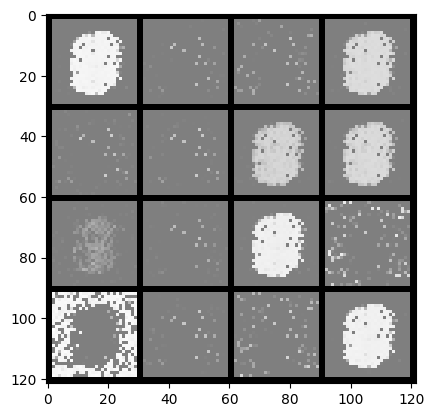

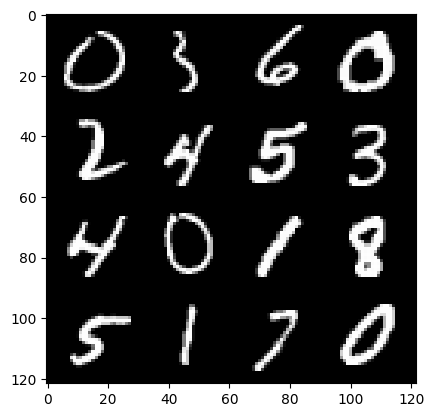

10: step 17700 / Gen loss: 6.896079273223877 / disc_loss: 0.005232032616622746


  0%|          | 0/469 [00:00<?, ?it/s]

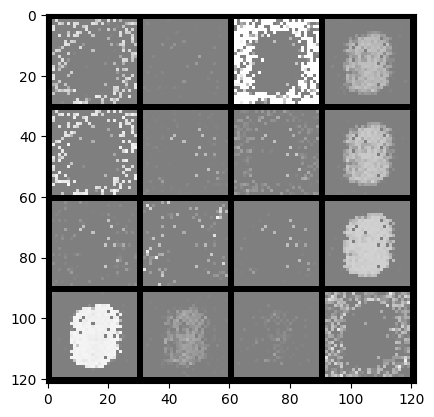

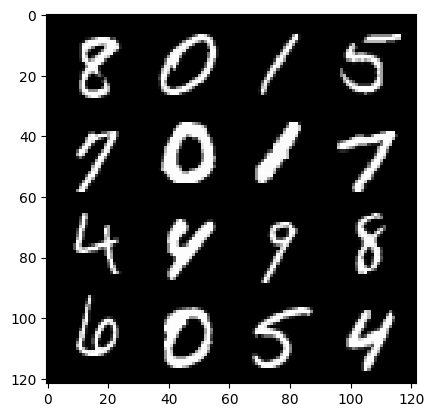

11: step 18000 / Gen loss: 7.175017628669743 / disc_loss: 0.00410233970731497


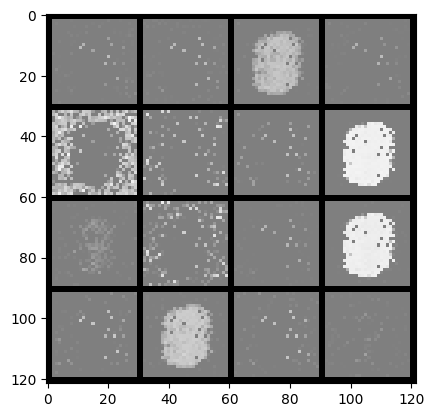

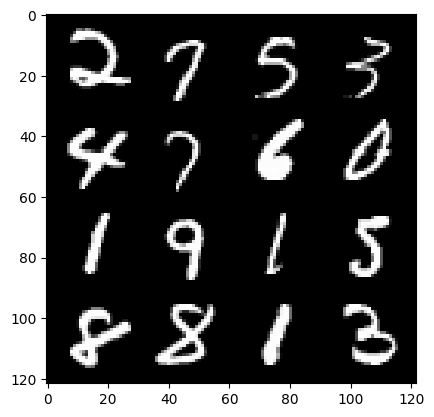

11: step 18300 / Gen loss: 7.435391554832452 / disc_loss: 0.003315252220878999


  0%|          | 0/469 [00:00<?, ?it/s]

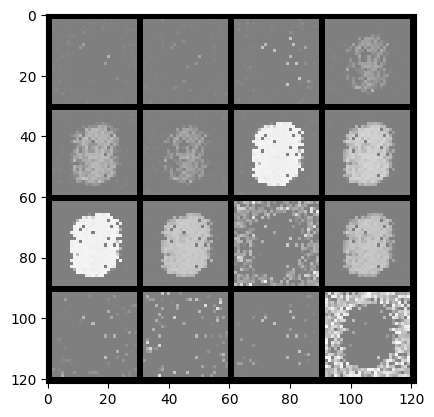

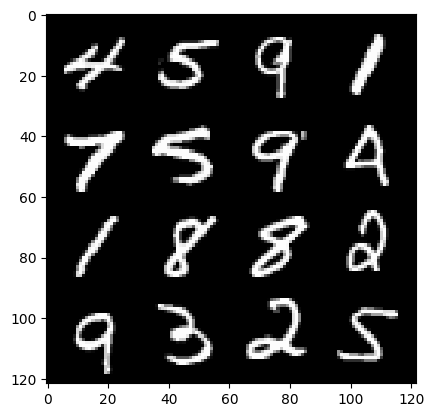

12: step 18600 / Gen loss: 7.685072417259214 / disc_loss: 0.002654734514265632


  0%|          | 0/469 [00:00<?, ?it/s]

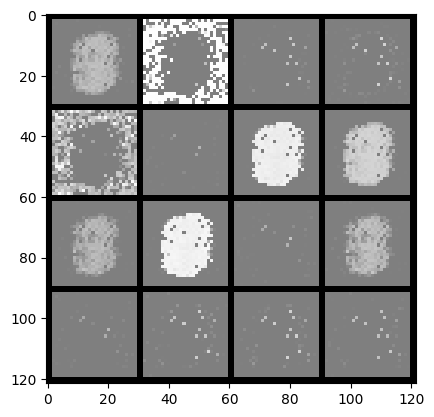

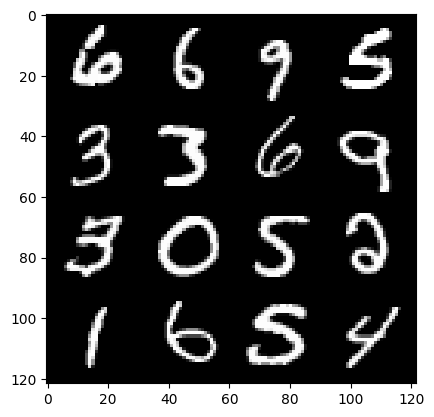

13: step 18900 / Gen loss: 7.926522216796876 / disc_loss: 0.0021322581463027756


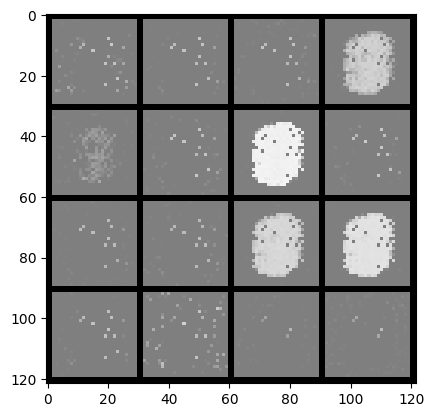

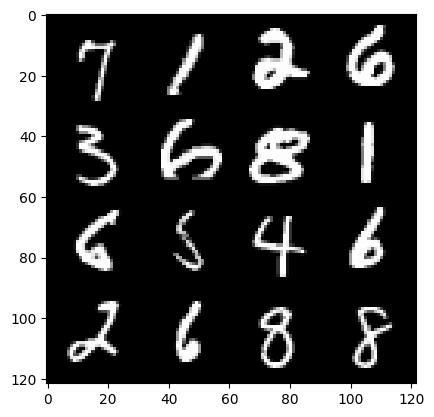

13: step 19200 / Gen loss: 8.168668093681333 / disc_loss: 0.0017484864782697208


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
### batch size = 128
### 60000 / 128 = 468.75  = 469 steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    # set the gradients to zero
    disc_opt.zero_grad()

    current_batch_size=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(current_batch_size, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,current_batch_size,real,z_dim)
    disc_loss.backward() # Backpropagation
    disc_opt.step() # Optimizer step

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,current_batch_size,z_dim)
    gen_loss.backward() # Backpropagation
    gen_opt.step() # Optimizer step

    ### statistics + visualization

    # adding the values into the losses
    mean_disc_loss+=disc_loss.item()/info_step # .item() transforms the tensor value into a standalone value
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(current_batch_size, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1


**In the quantitative assessment of GANs, especially for complex image datasets, which metrics are suitable for evaluating the quality and diversity of the generated images?**